

# Assignment 2: Lunar Lander 
**Task 1**

Student Name- Sandeep Dubey & Kshitija Shelar

Student Number- 20200220

Student Number- 20200155


In [ ]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras import backend as k
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint
import time

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from tensorflow.python.keras import utils
import csv
import os
import cv2
import random 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import PIL
from matplotlib import ticker
import seaborn as sb
import numpy as np

from imblearn.under_sampling import RandomUnderSampler
from keras.applications.vgg16 import VGG16

**Class Lunar Lander includes function to read and process input images, we are sampling input data and transforming each image to feed it to our network. We are only considering a single channel, as an input to the network. We are reducing input image dimension to 162,128 each single channeled as an input to LENET-5 network**

**We are setting the sample_rate to 0.3 for LENET-5 network. This means our notebook will use only 10% of the data.**

In [ ]:
class LunarLander():

  def __init__(self):
    self.ROWS = 162 # Target image width, after resizing and reshaping input image
    self.COLS = 128 #Target image height, after resizing and reshaping input image
    self.CHANNELS = 1 # We are only taking single channel as an input to our network. We will shrink 3 channeled input to single channel.
    self.sample_rate=0.3 # Sampling rate is %of data we are sampling from total number of images.
    self.input_shape=(self.ROWS, self.COLS,self.CHANNELS) # For lenet input shape is (162,128,1).
    self.image_filenames= {} #Dict to store all imagefiles inside the folder
    self.img_filenames=[]

    self.root_dir = "/content/drive/MyDrive/COMP47590 Assignment 2 LunarEirLander Dataset V2.zip (Unzipped Files)"

    self.nb_classes = 0

    self.model = Sequential()
    self.history = {}
    self.model_train_accuracy_comparision = dict()
    self.model_train_f1_score_comparision = dict()
    self.model_train_recall_comparision = dict()
    self.model_train_time_comparison = dict()
    self.model_test_accuracy_comparision = dict()
    self.model_test_f1_score_comparision = dict()
    self.model_test_recall_comparision = dict()
    self.model_test_time_comparision = dict()
    
  def mount_drive(self):
    from google.colab import drive
    drive.mount('/content/drive')

  def make_dir(self):
    
    dir =  [i for i in os.listdir(self.root_dir) if not "." in i]
    self.root_dir = self.root_dir+"/"
    dir = [i+"/" for i in dir]
    for index, i in enumerate(dir):
      self.image_filenames[i]=[i for i in os.listdir(self.root_dir+i) if not i.startswith(".")]

  def fetch_filename(self):
    for key in list(self.image_filenames.keys()):
      for i in range(len(self.image_filenames[key])):
        self.image_filenames[key][i]= key+self.image_filenames[key][i]

  def get_img(self):
    self.img_filenames=self.image_filenames['2021-03-04-10-02-03/']
    for i in range(1,len(list(self.image_filenames.keys()))):
      self.img_filenames.extend(self.image_filenames[list(self.image_filenames.keys())[i]])
    
  def print(self):
    print(len(self.img_filenames))

  def plot_img(self):
    fig = plt.figure(figsize=(15, 25))
    for i,path in enumerate(random.sample(self.img_filenames,10)):
      plt.subplot(5,2,i+1)
      img = cv2.imread(self.root_dir+path)
      plt.imshow(img)
      #print(img.shape)
    plt.show()

  def make_array(self):
    self.img_filenames = random.sample(self.img_filenames, int(len(self.img_filenames)*self.sample_rate))

    # Create a data array for image data
    count = len(self.img_filenames)
    #print(count)
    self.X_data = np.ndarray((count, self.ROWS, self.COLS, self.CHANNELS), dtype=np.float)
    print(self.X_data.shape)
    self.y_data= np.ndarray(0, dtype=np.int)
    print(len(self.img_filenames))

  def build_img(self):
    start = time.time

    # Iterate throuigh the filenames and for each one load the image, resize and normalise
    for i, image_file in enumerate(self.img_filenames): 
      image = cv2.imread(self.root_dir+image_file,cv2.IMREAD_GRAYSCALE)
      #print(image)
      image = cv2.resize(image, (self.ROWS, self.COLS))
      #print(image.shape)
      #Reshaping the image shape from (84,84) to (1,1,84,84)

      processed_image = image.reshape((1,self.ROWS, self.COLS, self.CHANNELS))
      self.X_data[i] = processed_image
      self.X_data[i] = self.X_data[i]/255
    
    end = time.time
   

  
  def label_extraction(self):
    y = []
    for img in self.img_filenames:
      #print(img[-6:-5])
      y.append(np.int(img[-6:-5]))
    self.y_data = np.array(y)
    print(self.X_data.shape)
  

  def split_train_test(self):
    self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X_data,self.y_data,test_size = 0.30,random_state = 1,train_size = 0.70)
    self.nb_classes  = len(set(self.y_data))

  
  def encoder(self):
    lb = sklearn.preprocessing.LabelEncoder()

    self.y_train_encoded = lb.fit_transform(self.y_train)
    self.y_test_encoded = lb.fit_transform(self.y_test)

    self.y_train_cat = keras.utils.np_utils.to_categorical(self.y_train_encoded,self.nb_classes)
    self.y_test_cat = keras.utils.np_utils.to_categorical(self.y_test_encoded,self.nb_classes)

#Lenet MOdel
  def build_model_lenet(self):
    self.model.add(Conv2D(32, (5, 5), input_shape=self.input_shape))
    self.model.add(Activation('relu'))
    self.model.add(MaxPooling2D(pool_size=(2, 2)))

    self.model.add(Conv2D(32, (5, 5)))
    self.model.add(Activation('relu'))
    self.model.add(MaxPooling2D(pool_size=(2, 2)))

    self.model.add(Conv2D(64, (5, 5)))
    self.model.add(Activation('relu'))
    self.model.add(MaxPooling2D(pool_size=(2, 2)))

    self.model.add(Flatten())
    self.model.add(Dense(256))
    self.model.add(Activation('relu'))
    self.model.add(Dropout(0.5))
    self.model.add(Dense(self.nb_classes))
    self.model.add(Activation('softmax'))

    self.model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    self.model.summary()

  



**Creating object of LunarLander class and mounting drive data from where will feed input images**

In [ ]:
lander = LunarLander()
lander.mount_drive()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 **Iterating over the images, making sure that they are jpeg or png. Creating a list of image names. Appending it to root dir to create address of each image .**

In [ ]:
lander.make_dir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Fetch filename and get_img would iterate over all file names in a directory and will try to fetch complete address till the image. Here we are only considering input images from a single folder given there are lot of images and it would be computationally very cumbersome.**

In [ ]:
lander.fetch_filename()
lander.get_img()


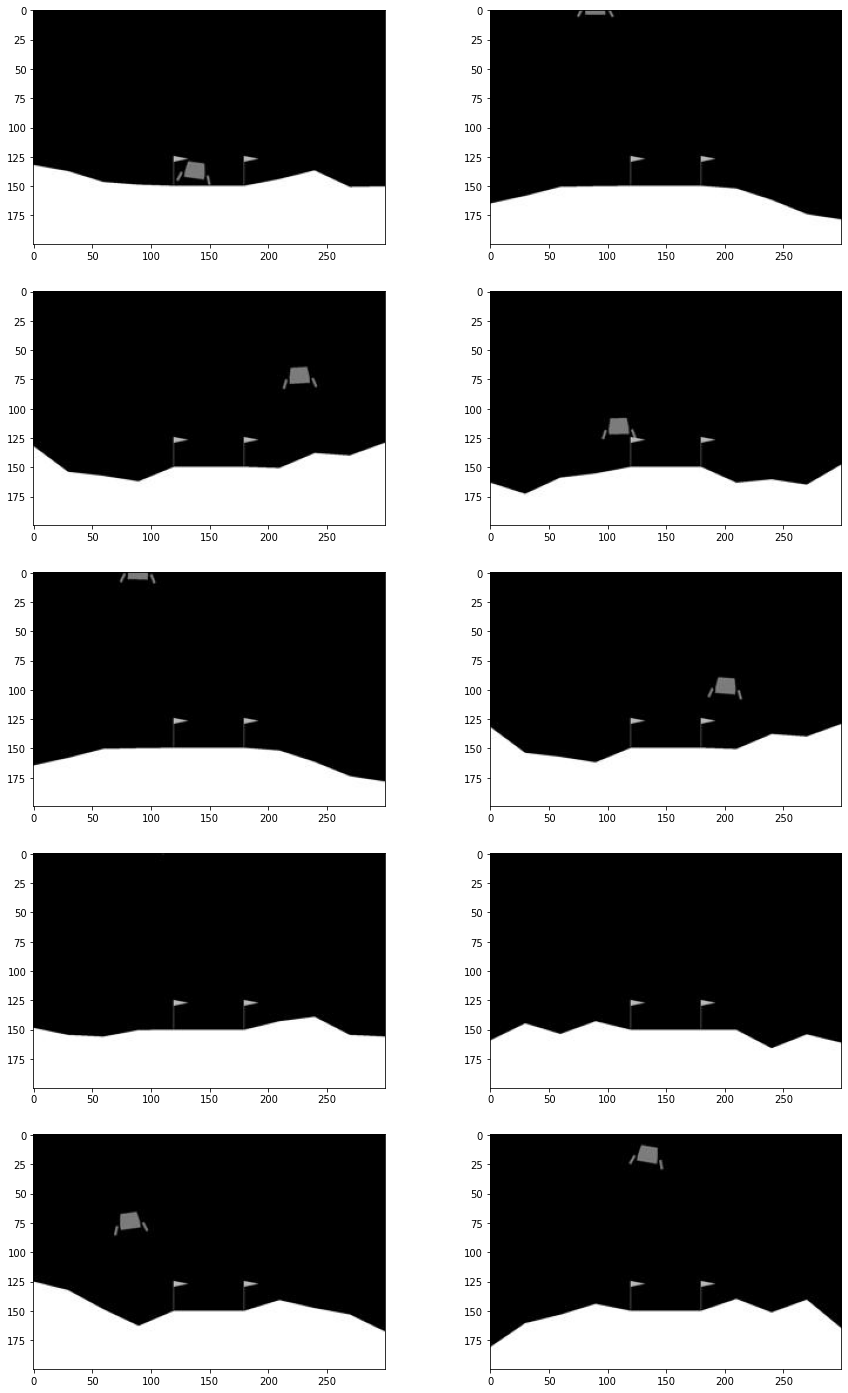

In [ ]:
lander.plot_img()

**Creating an ndarray of size (count,rows,cols,channels) to store all the input images as X and its corresponding label as Y. We are reading images from training data directory in a loop and convert each image to greyscale considering only single channel. Also we are reshaping it to (162,128) pixels from its original size of 1200800 pixels.
Then we are iterating over each image data array and normalizing it. We are also extracting the state of the game from the image filename and storing it in y_data.**



*   
*  






**Finding out the distribution of the y_data that contains the various state of the game.**


*   0 -none
*   1 -up
*   2 -left
*  3 -right


In [ ]:
lander.make_array()
lander.build_img()
lander.label_extraction()

(1830, 162, 128, 1)
1830


**Splitting input data into train and test set, considering 70:30 split for train and test set.**

In [ ]:
lander.split_train_test()


**Using Label encoder to encode each label into categories, passing as our y output **

In [ ]:
lander.encoder()

**After generating data, and preprocessing data will feed it to the network. As classes are imbalanced will also fixed class imbalance by undersampling for each model architecture and then testing different model architecture to classify state of images.**

**Here we are considering two networks, LENET-5 and VGG16**

1). LeNet-5 is one of the simplest architectures. It has 2 convolutional and 3 fully-connected layers (hence “5” — it is very common for the names of neural networks to be derived from the number of convolutional and fully connected layers that they have). The average-pooling layer as we know it now was called a sub-sampling layer and it had trainable weights (which isn’t the current practice of designing CNNs nowadays). This architecture has about 60,000 parameters.

2)VGG-16  model can be built both with 'channels_first' data format (channels, height, width) or 'channels_last' data format (height, width, channels).

The default input size for this model is 224x224.

Note: each Keras Application expects a specific kind of input preprocessing. For VGG16, call tf.keras.applications.vgg16.preprocess_input on your inputs before passing them to the model.

Arguments

    include_top: whether to include the 3 fully-connected layers at the top of the network.
    weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.
    input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
    input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with channels_last data format) or (3, 224, 224) (with channels_first data format). It should have exactly 3 input channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
    pooling: Optional pooling mode for feature extraction when include_top is False. - None means that the output of the model will be the 4D tensor output of the last convolutional block. - avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor. - max means that global max pooling will be applied.
    classes: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.
    classifier_activation: A str or callable. The activation function to use on the "top" layer.


## Performing evaluation on LENET-5 model

In [ ]:
lander.build_model_lenet()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 158, 124, 32)      832       
_________________________________________________________________
activation_5 (Activation)    (None, 158, 124, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 79, 62, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 58, 32)        25632     
_________________________________________________________________
activation_6 (Activation)    (None, 75, 58, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 29, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 25, 64)       

In [ ]:

batch_size = 128
epochs = 50

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_notebook_model1.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                  save_best_only=True, save_weights_only=True)

start = time.time()
lander.history = lander.model.fit(lander.X_train, lander.y_train_cat,
      batch_size=batch_size,
      epochs=epochs,
      verbose = 1,
      validation_split = 0.2,
      shuffle=True,
      callbacks=[mcp])
end = time.time()
timetaken=end - start
lander.model.save("Lenet-run1.hdf5") 


Epoch 1/50
8/8 [==============================] - 42s 5s/step - loss: 0.5500 - accuracy: 0.3528 - val_loss: 0.4073 - val_accuracy: 0.4864
Epoch 2/50
8/8 [==============================] - 41s 5s/step - loss: 0.4185 - accuracy: 0.5233 - val_loss: 0.3641 - val_accuracy: 0.6537
Epoch 3/50
8/8 [==============================] - 41s 5s/step - loss: 0.3796 - accuracy: 0.6283 - val_loss: 0.3731 - val_accuracy: 0.6459
Epoch 4/50
8/8 [==============================] - 41s 5s/step - loss: 0.4002 - accuracy: 0.6322 - val_loss: 0.3524 - val_accuracy: 0.6576
Epoch 5/50
8/8 [==============================] - 41s 5s/step - loss: 0.3945 - accuracy: 0.6363 - val_loss: 0.3534 - val_accuracy: 0.6498
Epoch 6/50
8/8 [==============================] - 41s 5s/step - loss: 0.3917 - accuracy: 0.6235 - val_loss: 0.3544 - val_accuracy: 0.6498
Epoch 7/50
8/8 [==============================] - 41s 5s/step - loss: 0.3742 - accuracy: 0.6437 - val_loss: 0.3509 - val_accuracy: 0.6576
Epoch 8/50
8/8 [==================

Count of labels checking distribution of the y_data that contains the various state of the game for without fixing class imbalance for LENET-5 model


*   0 -none
*   1 -up
*   2 -left
*  3 -right

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


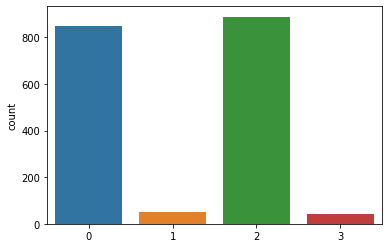

In [ ]:
import seaborn as sb
sb.countplot(lander.y_data)
plt.show()

In [ ]:
plt.plot(lander.history.history['accuracy'])
plt.plot(lander.history.history['val_accuracy'])
plt.title('Lenet-5 model accuracy without fixing class imbalance')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

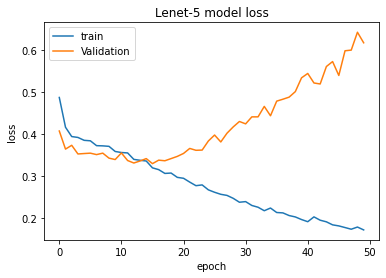

In [ ]:
plt.plot(lander.history.history['loss'])
plt.plot(lander.history.history['val_loss'])
plt.title('Lenet-5 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

We are getting 81.1% Accuracy by LENET-5 model without fixing class imbalance on training set. But their is class imbalance problem in the dataset, so we need to fix that problem. We can see from the confusion matrix, our model is not able to predict class 1 and class 3. Instead of them, it is simply predicting the majority class which is class 0 and class 2.

Also, we are getting accuracy of 63 on test set without fixing class imbalance for lenet-5 model.

```
# This is formatted as code
```



In [ ]:
import tensorflow as tf
from tensorflow import keras

myModel = tf.keras.models.load_model("./Lenet-run1.hdf5")

myModel.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = myModel.evaluate(lander.X_train, lander.y_train_cat, verbose=0)
print("Lenet accuracy on training set %s: %.2f%%" % (myModel.metrics_names[1], score[1]*100))
print("************")
print("************")
print("************")

lander.y_pred = myModel.predict_classes(lander.X_test)
# Print performance details
accuracy = metrics.accuracy_score(lander.y_test_encoded, lander.y_pred) # , normalize=True, sample_weight=None
lander.model_test_accuracy_comparision["Lenet-5"] = accuracy
print("Lenet accuracy on test set " +  str(accuracy))
print("************")
print("************")
print("************")

print("Lenet classfication report "+metrics.classification_report(lander.y_test_encoded, lander.y_pred))
report = metrics.classification_report(lander.y_test_encoded, lander.y_pred)
lander.model_test_recall_comparision["Lenet-5"] = report.split('\n')[-2].split('      ')[2]
lander.model_test_f1_score_comparision["Lenet-5"] = report.split('\n')[-2].split('      ')[3]
print("Confusion Matrix")
pd.crosstab(np.array(lander.y_test_encoded), lander.y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Lenet accuracy on training set accuracy: 81.11%
************
************
************


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Lenet accuracy on test set 0.6302367941712204
Lenet classfication report               precision    recall  f1-score   support

           0       0.62      0.68      0.65       253
           1       0.50      0.13      0.21        15
           2       0.65      0.64      0.65       266
           3       0.17      0.07      0.10        15

    accuracy                           0.63       549
   macro avg       0.49      0.38      0.40       549
weighted avg       0.62      0.63      0.62       549

Confusion Matrix


Predicted,0,1,2,3,All
True,,,,,
0,172,0,79,2,253
1,6,2,7,0,15
2,90,2,171,3,266
3,8,0,6,1,15
All,276,4,263,6,549


In [ ]:

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_train_rus, y_train_rus, id_rus =rus.fit_sample(lander.X_train.reshape(len(lander.X_train), lander.X_train.shape[1]*lander.X_train.shape[2]*lander.X_train.shape[3]), lander.y_train)

print(X_train_rus.shape)
print(y_train_rus.shape)

X_train_rus, y_train_rus = shuffle(X_train_rus, y_train_rus)

X_train_rus = X_train_rus.reshape(len(X_train_rus),lander.ROWS, lander.COLS,lander.CHANNELS)
X_rus, Y_rus = X_train_rus, y_train_rus

X_train_rus, X_test_rus, y_train_rus ,y_test_rus = train_test_split(X_rus,Y_rus,train_size=0.70,test_size = 0.30,random_state = 1)

from tensorflow.python.keras import utils 
lb = sklearn.preprocessing.LabelEncoder()

y_train_rus_encoded = lb.fit_transform(y_train_rus)
y_test_rus_encoded = lb.fit_transform(y_test_rus)

y_train_rus_cat = utils.np_utils.to_categorical(y_train_rus_encoded,lander.nb_classes)
y_test_rus_cat = utils.np_utils.to_categorical(y_test_rus_encoded,lander.nb_classes)
batch_size = 64
epochs = 50



# Set up the callback to save the best model based on validaion data


start = time.time()
lander.history = lander.model.fit(X_train_rus, y_train_rus_cat,
      batch_size=batch_size,
      epochs=epochs,
      verbose = 1,
      validation_split = 0.2,
      shuffle=True)
end = time.time()
timetaken=end - start
lander.model.save("Lenet-oversampling-run1.hdf5")


(116, 20736)
(116,)
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1/1 [==============================] - 3s 3s/step - loss: 0.4916 - accuracy: 0.7031 - val_loss: 0.4379 - val_accuracy: 0.7059
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: 0.4108 - accuracy: 0.7500 - val_loss: 0.3693 - val_accuracy: 0.7059
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: 0.3435 - accuracy: 0.7500 - val_loss: 0.3501 - val_accuracy: 0.7647
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 0.2834 - accuracy: 0.8125 - val_loss: 0.3550 - val_accuracy: 0.7647
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 0.2489 - accuracy: 0.8125 - val_loss: 0.3621 - val_accuracy: 0.8235
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 0.2168 - accuracy: 0.8594 - val_loss: 0.3692 - val_accuracy: 0.7059
Epoch 7/50
1/1 [==============================] - 3s 3s/step - loss: 0.2322 - accuracy: 0.8438 - val_loss: 0.3788 - val_accuracy: 0.7059
Epoch 8/50
1/1 [==============================] - 3s

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


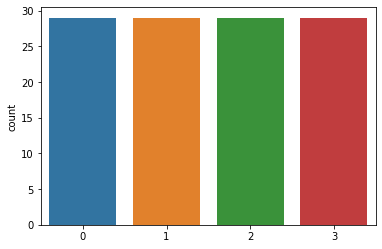

In [ ]:
import seaborn as sb
sb.countplot(Y_rus)
plt.show()

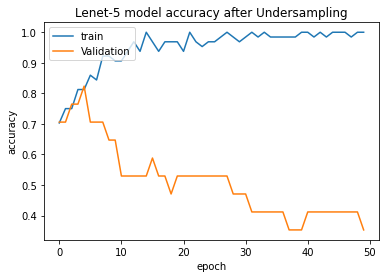

In [ ]:
plt.plot(lander.history.history['accuracy'])
plt.plot(lander.history.history['val_accuracy'])
plt.title('Lenet-5 model accuracy after Undersampling')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

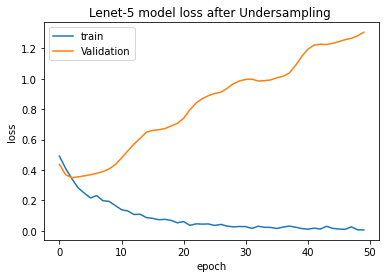

In [ ]:
plt.plot(lander.history.history['loss'])
plt.plot(lander.history.history['val_loss'])
plt.title('Lenet-5 model loss after Undersampling ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras

myModel_undersamp = tf.keras.models.load_model("./Lenet-oversampling-run1.hdf5")

myModel_undersamp.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = myModel_undersamp.evaluate(X_train_rus, y_train_rus_cat, verbose=0)
print("Lenet accuracy on training set after undersampling %s: %.2f%%" % (myModel_undersamp.metrics_names[1], score[1]*100))
print("************")
print("************")
print("************")

y_pred = myModel_undersamp.predict_classes(X_test_rus)
# Print performance details

print(len(y_pred))
print(len(y_test_rus_encoded))
accuracy = metrics.accuracy_score(y_test_rus_encoded , y_pred) # , normalize=True, sample_weight=None
lander.model_test_accuracy_comparision["Lenet-5-undersample"] = accuracy
print("Lenet accuracy on test set after undersampling" +  str(accuracy))

print("Lenet classfication report after undersampling"+metrics.classification_report(y_test_rus_encoded , y_pred))
report = metrics.classification_report(y_test_rus_encoded , y_pred)
lander.model_test_recall_comparision["Lenet-5-undersampled"] = report.split('\n')[-2].split('      ')[2]
lander.model_test_f1_score_comparision["Lenet-5-undersampled"] = report.split('\n')[-2].split('      ')[3]
print("Confusion Matrix")
pd.crosstab(np.array(y_test_rus_encoded), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Lenet accuracy on training set after undersampling accuracy: 86.42%
************
************
************


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


35
35
Lenet accuracy on test set after undersampling0.5142857142857142
Lenet classfication report after undersampling              precision    recall  f1-score   support

           0       0.36      0.71      0.48         7
           1       0.60      0.38      0.46         8
           2       0.70      0.64      0.67        11
           3       0.50      0.33      0.40         9

    accuracy                           0.51        35
   macro avg       0.54      0.51      0.50        35
weighted avg       0.56      0.51      0.51        35

Confusion Matrix


Predicted,0,1,2,3,All
True,,,,,
0,5,0,1,1,7
1,3,3,1,1,8
2,3,0,7,1,11
3,3,2,1,3,9
All,14,5,10,6,35


# Performing EValuation on VGG16

In [ ]:
lander2 = LunarLander()
lander2.mount_drive()
lander2.make_dir()
lander2.fetch_filename()
lander2.get_img()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# desired dimensions of our images.
ROWS = 224
COLS = 224
CHANNELS = 3
sample_rate=0.01

input_shape=(ROWS, COLS,CHANNELS)

lander2.img_filenames = random.sample(lander2.img_filenames, int(len(lander2.img_filenames)*sample_rate))

# Create a data array for image data
count = len(lander2.img_filenames)
lander2.X_data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.float)
lander2.y_data= np.ndarray(0, dtype=np.int)

In [ ]:


# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(lander2.img_filenames): 
    image = cv2.imread(lander2.root_dir+image_file)
    #print(image)
    image = cv2.resize(image, (ROWS, COLS))
    #print(image.shape)
    #Reshaping the image shape from (224,224) to (1,224,224,1)

    processed_image = image.reshape((1,ROWS, COLS, CHANNELS))
    lander2.X_data[i] = processed_image
    lander2.X_data[i] = lander2.X_data[i]/255
    
    

"""processed_image = image.reshape((1, CHANNELS, ROWS, COLS))
# Add image data to data array and normalise
X_data[i] = processed_image
X_data[i] = X_data[i]/255"""

'processed_image = image.reshape((1, CHANNELS, ROWS, COLS))\n# Add image data to data array and normalise\nX_data[i] = processed_image\nX_data[i] = X_data[i]/255'

In [ ]:
y= []
for img in lander2.img_filenames:
  print(img[-6:-5])
  y.append(np.int(img[-6:-5]))
lander2.y_data = np.array(y)

In [ ]:
X_train, X_test, y_train  , y_test = train_test_split(lander2.X_data,lander2.y_data,test_size = 0.30,random_state = 1,train_size = 0.70)

In [ ]:
nb_classes  = len(set(lander2.y_data))

In [ ]:
from tensorflow.python.keras import utils

lb = sklearn.preprocessing.LabelEncoder()

y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.fit_transform(y_test)

y_train_cat = utils.np_utils.to_categorical(y_train_encoded,nb_classes)
y_test_cat = utils.np_utils.to_categorical(y_test_encoded,nb_classes)



In [ ]:
classes_num_label = dict()

for idx, lbl in enumerate(lb.classes_):
    classes_num_label[idx] = lbl

In [ ]:
weights ='/content/drive/MyDrive/vgg16_weights_tf_dim_ordering_tf_kernels_notop_extracted.h5'

model1 = Sequential()
model1.add(VGG16(include_top = False, weights = weights, input_shape = (224,224,3)))
model1.add(Flatten())
model1.add(Dense(512, activation = 'relu'))
model1.add(Dense(5, activation = 'softmax'))
model1.compile(loss='sparse_categorical_crossentropy',
          optimizer='sgd',
          metrics=['accuracy'])

In [ ]:
batch_size = 128
epochs = 50

# Set up the callback to save the best model based on validaion data


start = time.time()
history = model1.fit(X_train, y_train_encoded,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True)
end = time.time()
timetaken=end - start


Epoch 1/50
1/1 [==============================] - 66s 66s/step - loss: 2.0483 - accuracy: 0.0000e+00 - val_loss: 5.9317 - val_accuracy: 0.4444
Epoch 2/50
1/1 [==============================] - 69s 69s/step - loss: 4.9620 - accuracy: 0.5758 - val_loss: 1.1380 - val_accuracy: 0.5556
Epoch 3/50
1/1 [==============================] - 64s 64s/step - loss: 1.3808 - accuracy: 0.3939 - val_loss: 1.2624 - val_accuracy: 0.7778
Epoch 4/50
1/1 [==============================] - 64s 64s/step - loss: 1.2818 - accuracy: 0.5455 - val_loss: 3.6581 - val_accuracy: 0.5556
Epoch 5/50
1/1 [==============================] - 65s 65s/step - loss: 5.2400 - accuracy: 0.3939 - val_loss: 1.2843 - val_accuracy: 0.5556
Epoch 6/50
1/1 [==============================] - 65s 65s/step - loss: 2.0189 - accuracy: 0.3939 - val_loss: 15.5116 - val_accuracy: 0.4444
Epoch 7/50
1/1 [==============================] - 64s 64s/step - loss: 11.8039 - accuracy: 0.5758 - val_loss: 0.9177 - val_accuracy: 0.5556
Epoch 8/50
1/1 [=====

In [ ]:
model1.save('vgg_lunar.hdf5')

We are getting 47% Accuracy by VGG16 model without fixing class imbalance on training set. But their is class imbalance problem in the dataset, so we need to fix that problem. We can see from the confusion matrix, our model is not able to predict class 1 and class 3. Instead of them, it is simply predicting the majority class which is class 0 and class 2.

Also, we are getting accuracy of 63 on test set without fixing class imbalance for lenet-5 model.

```
# This is formatted as code
```



In [ ]:
import tensorflow as tf
from tensorflow import keras
#...
myModel_vgg = tf.keras.models.load_model("./vgg_lunar.hdf5")
y_pred = myModel_vgg.predict_classes(X_test)
# Print performance details
accuracy = metrics.accuracy_score(y_test_encoded, y_pred) # , normalize=True, sample_weight=None
lander2.model_test_accuracy_comparision["VGG"] = accuracy
print("Accuracy: " +  str(accuracy))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.47368421052631576


In [ ]:
print(metrics.classification_report(y_test_encoded, y_pred))
report = metrics.classification_report(y_test_encoded, y_pred)
lander2.model_test_recall_comparision["VGG"] = report.split('\n')[-2].split('      ')[2]
lander2.model_test_f1_score_comparision["VGG"] = report.split('\n')[-2].split('      ')[3]
print("Confusion Matrix")
pd.crosstab(np.array(y_test_encoded), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.47      1.00      0.64         9
           1       0.00      0.00      0.00        10

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19

Confusion Matrix


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicted,0,All
True,,
0,9,9
1,10,10
All,19,19


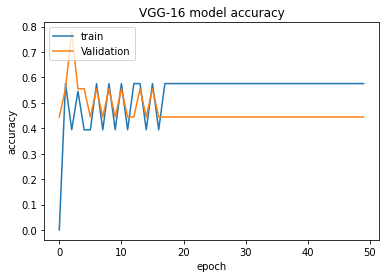

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG-16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

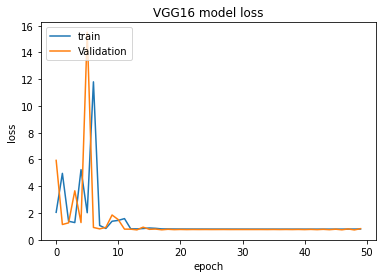

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = myModel_vgg.predict_classes(X_test)
# Print performance details
accuracy = metrics.accuracy_score(y_test_encoded, y_pred) # , normalize=True, sample_weight=None
lander2.model_test_accuracy_comparision["VGG16"] = accuracy
print("Accuracy: " +  str(accuracy))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.47368421052631576


In [ ]:
print(metrics.classification_report(y_test_encoded, y_pred))
report = metrics.classification_report(y_test_encoded, y_pred)
lander2.model_test_recall_comparision["VGG16"] = report.split('\n')[-2].split('      ')[2]
lander2.model_test_f1_score_comparision["VGG16"] = report.split('\n')[-2].split('      ')[3]
print("Confusion Matrix")
pd.crosstab(np.array(y_test_encoded), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


              precision    recall  f1-score   support

           0       0.47      1.00      0.64         9
           1       0.00      0.00      0.00        10

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19

Confusion Matrix


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicted,0,All
True,,
0,9,9
1,10,10
All,19,19


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_train_rus, y_train_rus, id_rus =rus.fit_sample(X_train.reshape(len(X_train), X_train.shape[1]*X_train.shape[2]*X_train.shape[3]), y_train)

print(X_train_rus.shape)
print(y_train_rus.shape)

X_train_rus, y_train_rus = shuffle(X_train_rus, y_train_rus)

X_train_rus = X_train_rus.reshape(len(X_train_rus),ROWS, COLS,CHANNELS)

X_rus, Y_rus = X_train_rus, y_train_rus

X_train_rus, X_test_rus, y_train_rus ,y_test_rus = train_test_split(X_rus,Y_rus,train_size=0.70,test_size = 0.30,random_state = 1)

(3, 150528)
(3,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
 from tensorflow.python.keras import utils

lb = sklearn.preprocessing.LabelEncoder()

y_train_rus_encoded = lb.fit_transform(y_train_rus)
y_test_rus_encoded = lb.fit_transform(y_train_rus)

y_train_rus_cat = utils.np_utils.to_categorical(y_train_rus_encoded,nb_classes)
y_test_rus_cat = utils.np_utils.to_categorical(y_test_rus_encoded,nb_classes)



In [ ]:
import time
batch_size = 64
epochs = 50

# Set up the callback to save the best model based on validaion data


start = time.time()
history = model1.fit(X_train_rus, y_train_rus_encoded,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True)
end = time.time()
timetaken=end - start
model1.save("VGG-underrsampling-run1.hdf5")


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.4254 - accuracy: 1.0000 - val_loss: 6.8822 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - accuracy: 1.0000 - val_loss: 7.3565 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 7.7118 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 7.9921 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 8.2296 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 8.4350 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 8.6171 - val_accuracy: 0.0000e+00
Epoch 8/50
1/

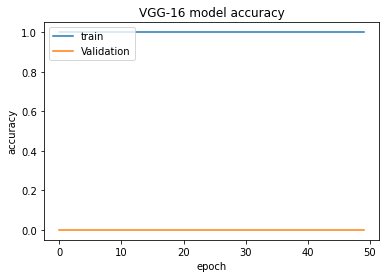

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG-16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()